In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import ast
import glob
import csv

In [3]:
# Define a function to convert a string representation of a list to a float
def parse_string_to_float(s):
    try:
        # Attempt to evaluate the string as a literal expression (list),
        # and then convert the first element to a float
        return float(ast.literal_eval(s)[0])
    except (ValueError, SyntaxError):
        # If there is an error, return NaN
        return np.nan

# Define a function to calculate the metrics
def calculate_metrics(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Apply the conversion function to each row in the 'target' and 'output' columns
    df['target'] = df['target'].apply(parse_string_to_float)
    df['output'] = df['output'].apply(parse_string_to_float)

    # Drop any rows that contain NaN values
    df = df.dropna()

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(df["target"], df["output"]))
    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(df["target"], df["output"])
    # Calculate R2 Score (Coefficient of Determination)
    r2 = r2_score(df["target"], df["output"])
    # Calculate PCC (Pearson Correlation Coefficient)
    pcc, _ = pearsonr(df["target"], df["output"])

    # Return the calculated metrics
    return rmse, mae, r2, pcc

In [4]:
# Assuming calculate_metrics function is already defined as shown above

# Define the path for the output CSV file
output_csv_path = "ablation_without_substructure_extract.csv"  # Change this to your desired output path

# Open the output CSV file for writing
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['file_label', 'train_rmse', 'train_mae', 'train_r2', 'train_pcc', 'test_rmse', 'test_mae', 'test_r2', 'test_pcc'])

    # Iterate over the folders and files, calculate metrics, and write to the CSV
    for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/Ablation_study/without_substructure_extract/train_reslut/*"):
        fold_label = fold.split("/")[-1]
        fold_files = glob.glob(f"{fold}/Metal/edge_attr/*")
        for file in fold_files:
            file_label = fold_label +  "_" + file.split("/")[-1].split("_0.2_")[0] + "_nosat"
            
            # Construct the file paths for train and test CSV files
            train_csv_path = f"{file}/train_output.csv"
            test_csv_path = f"{file}/test_output.csv"
            
            # Calculate metrics for train dataset
            train_rmse, train_mae, train_r2, train_pcc = calculate_metrics(train_csv_path)
            print(train_rmse, train_mae, train_r2, train_pcc)
            # Calculate metrics for test dataset
            test_rmse, test_mae, test_r2, test_pcc = calculate_metrics(test_csv_path)
            print(test_rmse, test_mae, test_r2, test_pcc)
            
            # Write the metrics to the CSV file
            writer.writerow([file_label, train_rmse, train_mae, train_r2, train_pcc, test_rmse, test_mae, test_r2, test_pcc])

print(f"Metrics have been written to {output_csv_path}")

1.0028476567900912 0.3664031966652012 0.9726326274177279 0.9864766127843168
2.0690908400949044 0.8634049787776161 0.8969565050881987 0.9471148246873042
1.012869115350609 0.4237083933801596 0.9720829300959495 0.9859852829468585
2.0614182531947938 0.9029531351482595 0.8977192983755738 0.9478669886087498
1.0200788500564164 0.40917375304238335 0.9716840808973662 0.98574119503649
2.0761760942876224 0.8899399670025775 0.8962495864992299 0.9475900216857938
1.0487982603140218 0.42248105768933286 0.9700672172792426 0.9851502020938743
2.1915063491553086 0.9317847344711536 0.884402902284525 0.940676260987635
1.1306813642293452 0.5128296900622309 0.9660162559372726 0.9829405476632221
1.5470030689864174 0.6842135070958211 0.9339488470299202 0.96659328743519
0.9937394118153798 0.42353268486257106 0.9737496085217323 0.9868182950941078
1.4506975754707427 0.645774800984459 0.9419166277751513 0.9705467535711378
1.00144315447203 0.4242085795600854 0.9733410303469884 0.9866019733287305
1.4747309180645647 

In [5]:
import pandas as pd

# Assume your data is stored in a CSV file
file_path = "ablation_without_substructure_extract.csv"

# Read the data
df = pd.read_csv(file_path)

# Extract labels, remove 'foldX_' prefix, and keep everything before the last underscore
df['label'] = df['file_label'].str.replace(r'^fold[1-9]_|^fold10_', '', regex=True)

# Ensure only numeric columns are selected for aggregation
numeric_cols = df.select_dtypes(include=[float, int]).columns
agg_dict = {col: ['mean', 'std'] for col in numeric_cols}

# Group the data and aggregate only numeric columns
grouped = df.groupby('label')
result = grouped.agg(agg_dict)

# Format as 'mean ± std' and keep three decimal places
for col in numeric_cols:
    result[(col, 'formatted')] = result[(col, 'mean')].map('{:.3f}'.format) + " ± " + result[(col, 'std')].map('{:.3f}'.format)

# Select the formatted columns
formatted_columns = [(col, 'formatted') for col in numeric_cols]
result_formatted = result[formatted_columns]

# Rename the columns, remove multi-level index
result_formatted.columns = [col[0] for col in result_formatted.columns.values]

# Reset the index, making label as a column
result_formatted.reset_index(inplace=True)

# Output to a CSV file
result_formatted.to_csv('ablation_without_substructure_extract_outformatted.csv', index=False)

print("Formatted CSV file has been generated.")

Formatted CSV file has been generated.


In [2]:
import pandas as pd

df1 = pd.read_csv('/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_result_formatted.csv')
df2 = pd.read_csv('ablation_without_substructure_extract_outformatted.csv')

combined_df = pd.concat([df1, df2])
sorted_df = combined_df.sort_values(by='label')

sorted_df.to_csv('combined_ablation_without_substructure_extract_outformatted.csv', index=False)

/tmp/ipykernel_663793/4039114084.py:71: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=2.9, right=0.9, top=0.8, bottom=0.1)


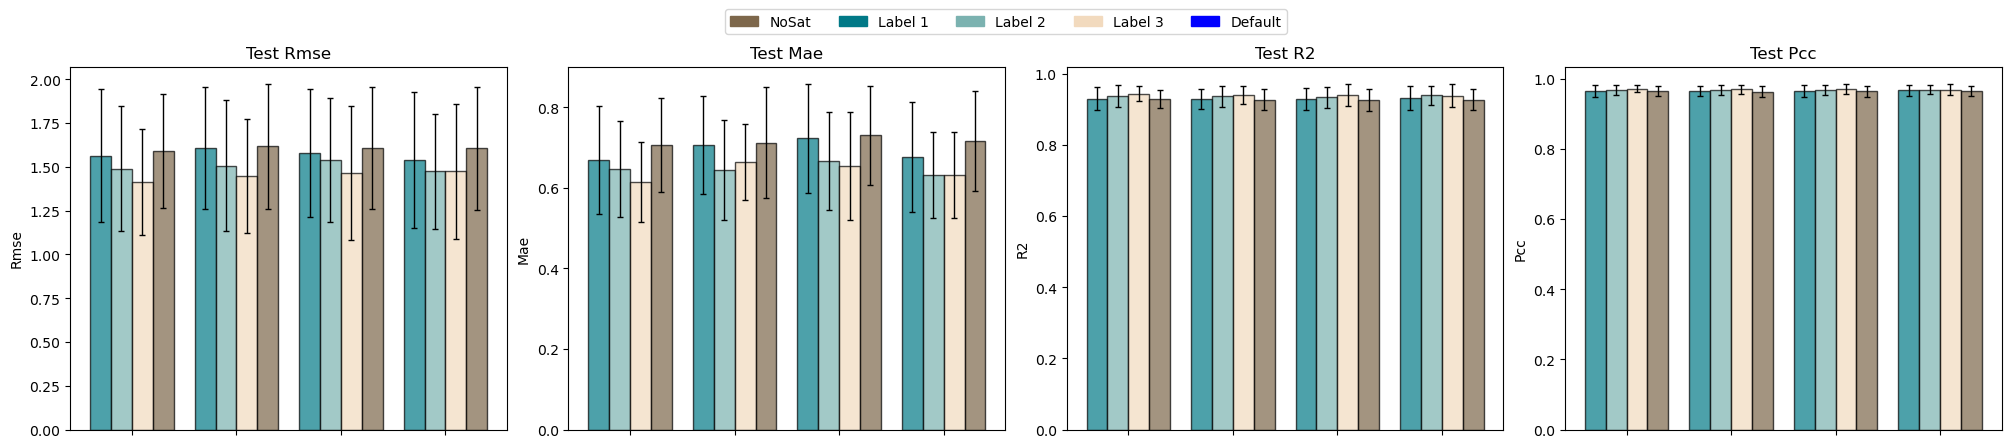

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from a CSV file
file_path = 'combined_ablation_without_substructure_extract_outformatted.csv'
df = pd.read_csv(file_path)

# Parse mean and standard deviation
for col in df.columns[1:]:
    df[[f'{col}_mean', f'{col}_std']] = df[col].str.extract(r'([0-9.]+) ± ([0-9.]+)').astype(float)

# Set figure size and layout
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), constrained_layout=True)

# Draw bar charts
metrics = df.columns[1:].str.replace(r'(_mean|_std)$', '').unique()
metrics = [metric for metric in metrics if 'test' in metric.lower()]  # Only keep metrics that contain "Test"
bar_width = 0.20  # Bar width
error_kw = {'capsize': 2, 'capthick': 1, 'elinewidth': 1}  # Adjust the appearance of the error bars

# Color settings
color_nosat = (125/255, 103/255, 75/255)
color_1 = (1/255, 121/255, 135/255)
color_2 = (123/255, 178/255, 176/255)
color_3 = (242/255, 218/255, 190/255)
color_default = (0, 0, 1)  # Default color is blue in RGB, normalized

for ax, metric in zip(axes, metrics):
    means = df[f'{metric}_mean']
    stds = df[f'{metric}_std']
    labels = df['label']
    
    # Ensure the number of labels can be divided by 4
    if len(labels) % 4 != 0:
        raise ValueError("The number of labels must be divisible by 4 for pairwise grouping.")
    
    # Calculate the positions of the bar groups
    n_groups = len(labels) // 4
    x_pos = np.arange(n_groups) * (bar_width * 5)
    
    colors = [
        color_nosat if 'nosat' in label else
        color_1 if label.split("_")[-1] == '1' else
        color_2 if label.split("_")[-1] == '2' else
        color_3 if label.split("_")[-1] == '3' else
        color_default
        for label in labels
    ]

    # Draw the bars with borders, and adjust the top of the error bars
    bars = [ax.bar(x_pos + i * bar_width, means[i::4], yerr=stds[i::4], width=bar_width,
                   align='center', alpha=0.7, color=colors[i::4], edgecolor='black', error_kw=error_kw)
            for i in range(4)]
    
    # Set the tick positions of the x-axis, but do not display the labels
    ax.set_xticks(x_pos + bar_width * 1.5)
    ax.set_xticklabels([])  # Do not display x-axis labels
    
    # Set title, x-axis and y-axis labels
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('')  # Do not display x-axis label
    ax.set_ylabel(metric.split('_')[1].title())

# Add legend
legend_labels = ['NoSat', 'Label 1', 'Label 2', 'Label 3', 'Default']
fig.legend([plt.Rectangle((0,0),1,1, color=c) for c in [color_nosat, color_1, color_2, color_3, color_default]],
           legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)

# Adjust subplot spacing
plt.subplots_adjust(left=2.9, right=0.9, top=0.8, bottom=0.1) 

# Save the figure
# plt.savefig('bar_chart.png', dpi=1200)

# Display the figure
plt.show()

/tmp/ipykernel_1069560/1656240464.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1f}'.format(x) for x in ax.get_yticks()])


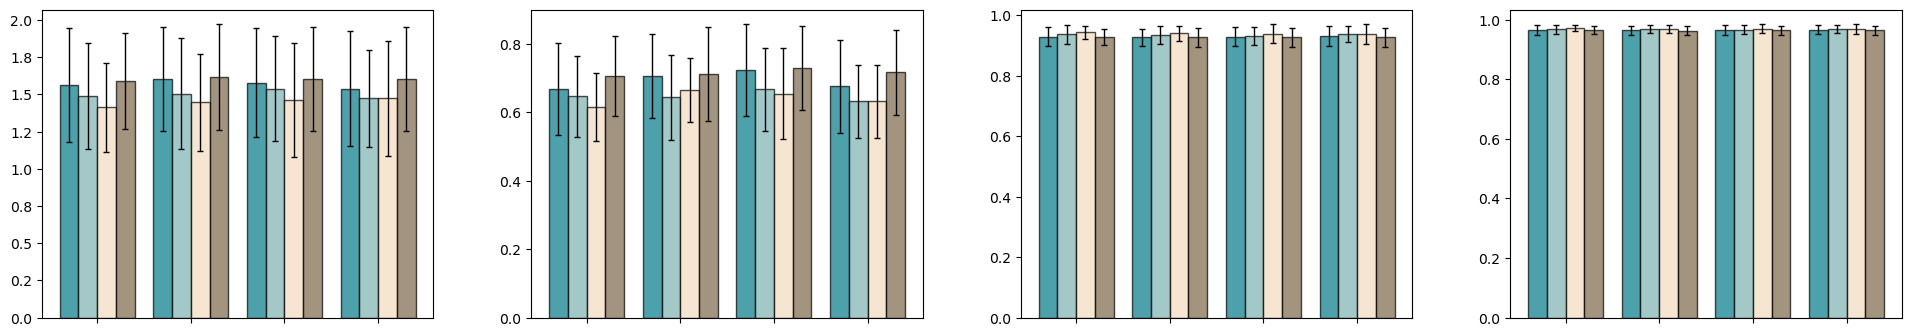

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from a CSV file
file_path = 'combined_ablation_without_substructure_extract_outformatted.csv'
df = pd.read_csv(file_path)

# Parse mean and standard deviation
for col in df.columns[1:]:
    df[[f'{col}_mean', f'{col}_std']] = df[col].str.extract(r'([0-9.]+) ± ([0-9.]+)').astype(float)

# Set figure size and layout, remove `constrained_layout=True` to avoid layout conflicts
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 4))

# Plot bar charts
metrics = df.columns[1:].str.replace(r'(_mean|_std)$', '').unique()
metrics = [metric for metric in metrics if 'test' in metric.lower()]  # Only keep metrics that contain "Test"
bar_width = 0.20  # Width of the bars
error_kw = {'capsize': 2, 'capthick': 1, 'elinewidth': 1}  # Adjust the appearance of error bars

# Color settings
color_nosat = (125/255, 103/255, 75/255)
color_1 = (1/255, 121/255, 135/255)
color_2 = (123/255, 178/255, 176/255)
color_3 = (242/255, 218/255, 190/255)
color_default = (0, 0, 1)  # Default color is normalized blue RGB

for ax, metric in zip(axes, metrics):
    means = df[f'{metric}_mean']
    stds = df[f'{metric}_std']
    labels = df['label']
    
    # Ensure the number of labels is divisible by 4 for grouping
    if len(labels) % 4 != 0:
        raise ValueError("The number of labels must be divisible by 4 for pairing.")
    
    # Calculate the positions for the groups of bars
    n_groups = len(labels) // 4
    x_pos = np.arange(n_groups) * (bar_width * 5)
    
    colors = [
        color_nosat if 'nosat' in label else
        color_1 if label.split("_")[-1] == '1' else
        color_2 if label.split("_")[-1] == '2' else
        color_3 if label.split("_")[-1] == '3' else
        color_default
        for label in labels
    ]

    # Draw bars with borders and adjust the error bar caps
    bars = [ax.bar(x_pos + i * bar_width, means[i::4], yerr=stds[i::4], width=bar_width,
                   align='center', alpha=0.7, color=colors[i::4], edgecolor='black', error_kw=error_kw)
            for i in range(4)]
    
    # Set the x-axis tick positions but do not display labels
    ax.set_xticks(x_pos + bar_width * 1.5)
    ax.set_xticklabels([])  # Do not show x-axis labels
    
    # Remove code for setting titles and y-axis labels
    # ax.set_title(metric.replace('_', ' ').title())  # Removed title
    ax.set_ylabel('')  # Removed y-axis label
    ax.set_yticklabels(['{:.1f}'.format(x) for x in ax.get_yticks()])

# Adjust subplot spacing to increase space between subplots
plt.subplots_adjust(wspace=0.25)  # Adjust width spacing

# Save the figure
plt.savefig('without_substructure_extract.png', dpi=1000, bbox_inches='tight')

# Display the figure
plt.show()


In [ ]:
import os

# 定义旧文件夹名称和新文件夹名称
old_folder = "/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/Ablation_study/without_substructure_extract/train_reslut/fold1/Metal/seed124/edge_attr/old_name"
new_folder = "/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/Ablation_study/without_substructure_extract/train_reslut/fold1/Metal/seed124/edge_attr/new_name"

# 使用os.rename()来重命名文件夹
os.rename(old_folder, new_folder)

In [11]:
import os
for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/Ablation_study/without_substructure_extract/train_reslut/*"):
    fold_label = fold.split("/")[-1]
    fold_files = glob.glob(f"{fold}/Metal/seed124/edge_attr/*")
    for file in fold_files:
        new_file = file.replace("Metal/seed124/edge_attr", "Metal/edge_attr")
        os.rename(file, new_file)
        # print(file)
        # print(new_file)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/Ablation_study/without_substructure_extract/train_reslut/fold4/Metal/seed124/edge_attr/graphsage_0_0.2_0.001_1e-05_6_8_64_BN_2023-11-29_01-08-07_use_fp_density_morgan' -> '/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/Ablation_study/without_substructure_extract/train_reslut/fold4/Metal/edge_attr/graphsage_0_0.2_0.001_1e-05_6_8_64_BN_2023-11-29_01-08-07_use_fp_density_morgan'

In [10]:
import os
import glob
import shutil

# 遍历每个fold文件夹
for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/*"):
    # 获取fold的标签
    fold_label = fold.split("/")[-1]
    # 旧文件夹路径
    old_dir = os.path.join(fold, "Metal/seed124/edge_attr")
    # 目标文件夹的路径
    target_dir = old_dir.replace("seed124/edge_attr", "edge_attr")
    
    # 如果目标文件夹不存在，创建它
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # 获取所有需要移动的文件
    fold_files = glob.glob(f"{old_dir}/*")
    
    # 移动每个文件
    for file in fold_files:
        # 获取文件名
        file_name = os.path.basename(file)
        # 创建新的文件路径
        new_file = os.path.join(target_dir, file_name)
        # 移动文件
        os.rename(file, new_file)
    
    # 检查原始文件夹是否为空，如果为空，则删除它
    if not os.listdir(old_dir):
        os.rmdir(old_dir)
    else:
        # 如果文件夹不为空（即存在未知文件或子文件夹），使用shutil.rmtree()删除
        shutil.rmtree(old_dir)

In [4]:
import shutil
import glob

# 设置seed124文件夹的路径
seed124_dir = "/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result143/fold*//Metal/edge_attr/khopgnn_mpnn*"

# 使用glob找到所有匹配的文件夹路径
for dir_path in glob.glob(seed124_dir):
    print(dir_path)
    # 删除文件夹及其所有内容
    # shutil.rmtree(dir_path)

In [ ]:
/mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158

In [8]:
import os
import glob
import shutil

for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result142/*"):
    fold_label = fold.split("/")[-1]
    fold_files = glob.glob(f"{fold}/Metal/edge_attr/khopgnn_mpnn*")
    for file in fold_files:
        new_file = "/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result143/" + fold_label + "/Metal/edge_attr/" + file.split("/")[-1]
        shutil.copytree(file, new_file)
        print(file)
        print(new_file)


/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result142/fold4/Metal/edge_attr/khopgnn_mpnn_3_0.2_50_0.001_1e-05_6_8_64_cls_BN_2023-12-21_02-06-55
/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result143/fold4/Metal/edge_attr/khopgnn_mpnn_3_0.2_50_0.001_1e-05_6_8_64_cls_BN_2023-12-21_02-06-55
/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result142/fold4/Metal/edge_attr/khopgnn_mpnn_2_0.2_50_0.001_1e-05_6_8_64_cls_BN_2023-12-21_01-44-02
/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result143/fold4/Metal/edge_attr/khopgnn_mpnn_2_0.2_50_0.001_1e-05_6_8_64_cls_BN_2023-12-21_01-44-02
/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/ablation_study/without_morgan_fingerprint/ablation_study_result142/fold4/Metal/edge_attr/khopgnn_mpnn_1_0.2_50_0.001_1e-05_6_8_64_cls_BN_2023-12-21_01-22-16


In [14]:
import glob
import shutil
import os

def copy_folder_contents(src_folder, dst_folder):
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)
    
    for item in os.listdir(src_folder):
        s = os.path.join(src_folder, item)
        d = os.path.join(dst_folder, item)
        if os.path.isdir(s):
            copy_folder_contents(s, d)
        else:
            shutil.copy2(s, d)

for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158/*"):
    fold_label = fold.split("/")[-1]
    source_folder = f"{fold}/Metal/seed158/edge_attr/"
    target_folder = f"/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/{fold_label}/Metal/edge_attr/"

    copy_folder_contents(source_folder, target_folder)

    print(f"Copied contents of {source_folder} to {target_folder}")

Copied contents of /mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158/fold4/Metal/seed158/edge_attr/ to /mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/fold4/Metal/edge_attr/
Copied contents of /mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158/fold3/Metal/seed158/edge_attr/ to /mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/fold3/Metal/edge_attr/
Copied contents of /mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158/fold6/Metal/seed158/edge_attr/ to /mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/fold6/Metal/edge_attr/
Copied contents of /mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158/fold2/Metal/seed158/edge_attr/ to /mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/fold2/Metal/edge_attr/
Copied contents of /mnt/USR_DATA/ChenGeng/Project/SATCMF/train_reslut158/fold9/Metal/seed158/edge_attr/ to /mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SAT

In [13]:
for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/*"):
    fold_label = fold.split("/")[-1]
    fold_files = glob.glob(f"{fold}/Metal/edge_attr/*")
    for file in fold_files:
        if file.split("/")[-1].split("_")[1] in ["gcn"]:
            shutil.rmtree(file)
            # print(file)